### This is the topic modelling code for NMF, for specifically the reviews ### 

Credit for a lot of instructional guidance and good code goes to Albert Opoku (opokualbert) on Github at https://github.com/opokualbert/Topic-Modeling-with-Non-Negative-Matrix-Factorization-NMF-/blob/master/Consumer%20Financial%20Complaint%20Topic%20Modeling-Data%20Prep%20part1.ipynb

In [3]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text
from sklearn.decomposition import NMF
import numpy as np
import pickle 
import warnings  
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline

import nltk 
# from nltk.corpus import stopwords
from nltk import word_tokenize, pos_tag
# from nltk.stem import PorterStemmer
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/vaishnavisingh/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/vaishnavisingh/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
df_orig = pd.read_csv("/Users/vaishnavisingh/Desktop/unique_data.csv")


In [5]:
df_orig.shape


(102326, 35)

In [6]:
df_orig.head()

## this is the original preprocessed table-like form of the data


review_stars          review_date  \
0           3.0  2014-09-10 23:19:21   
1           4.0  2013-10-30 20:03:09   
2           3.0  2013-08-08 15:11:13   
3           3.0  2014-01-25 19:21:47   
4           4.0  2014-01-28 17:12:32   

                                         review_text  review_useful  \
0  Yet again.. Disappointed. Now they don't have ...              0   
1  Ok really?  When I see a bar that smells like ...              5   
2  The K-T is a decent place.  the bartenders are...              1   
3  Food four stars!!!!! Bartender shorting me 10 ...              0   
4  OK they get the star back for service.  Even a...              1   

   review_funny  review_cool user_name  user_review_count  \
0             1            1    Alison                146   
1             0            1    Alison                146   
2             1            1    Alison                146   
3             1            0    Alison                146   
4             1            1    Alison                146   

    user_yelping_since  user_useful  ...  user_compliment_photos  \
0  2011-12-05 22:07:12          220  ...                       0   
1  2011-12-05 22:07:12          220  ...                       0   
2  2011-12-05 22:07:12          220  ...                       0   
3  2011-12-05 22:07:12          220  ...                       0   
4  2011-12-05 22:07:12          220  ...                       0   

                                  tip_text             tip_date  \
0  Yum!!! Thanks for an amazing experience  2013-10-04 22:52:17   
1  Yum!!! Thanks for an amazing experience  2013-10-04 22:52:17   
2  Yum!!! Thanks for an amazing experience  2013-10-04 22:52:17   
3  Yum!!! Thanks for an amazing experience  2013-10-04 22:52:17   
4  Yum!!! Thanks for an amazing experience  2013-10-04 22:52:17   

  tip_compliment_count   business_name  business_state  business_stars  \
0                    0  Keswick Tavern              PA             3.5   
1                    0  Keswick Tavern              PA             3.5   
2                    0  Keswick Tavern              PA             3.5   
3                    0  Keswick Tavern              PA             3.5   
4                    0  Keswick Tavern              PA             3.5   

   business_review_count                                business_categories  \
0                    159  Bars, Greek, Restaurants, Nightlife, Beer, Win...   
1                    159  Bars, Greek, Restaurants, Nightlife, Beer, Win...   
2                    159  Bars, Greek, Restaurants, Nightlife, Beer, Win...   
3                    159  Bars, Greek, Restaurants, Nightlife, Beer, Win...   
4                    159  Bars, Greek, Restaurants, Nightlife, Beer, Win...   

   business_type  
0            F&B  
1            F&B  
2            F&B  
3            F&B  
4            F&B  

[5 rows x 35 columns]

In [7]:

# Load the dataset with only the desired columns
df = pd.read_csv("/Users/vaishnavisingh/Desktop/unique_data.csv", usecols=["review_text"])

# Now df contains only the "review_text" and "tip_text" columns
df.head()

## There's so many duplicates
unique_df = df.drop_duplicates(subset='review_text')


unique_df.head()


review_text
0  Yet again.. Disappointed. Now they don't have ...
1  Ok really?  When I see a bar that smells like ...
2  The K-T is a decent place.  the bartenders are...
3  Food four stars!!!!! Bartender shorting me 10 ...
4  OK they get the star back for service.  Even a...

In [8]:
pd.set_option('max_colwidth', 1000)
pd.options.display.max_rows = 500

In [9]:
# Create a doc id for merging the results back to the original file 
df.insert(0, 'Doc_Id', range(0, 0 + len(df_orig)))
df.head()

Doc_Id  \
0       0   
1       1   
2       2   
3       3   
4       4   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        review_text  
0                                                                                                                                                                                                                                                                                                                                                                                                                            Yet again.. Disappointed. Now they don't have bruschetta. Really bad deal. Stop placating people. Wrong deal. Bad service all the sudden. Never really bad before. Really disappointed  
1                                                                                                                                                                                Ok really?  When I see a bar that smells like mold and smoke have a higher rating I get really pissed off. The KT is GOOD! They got rid of scum bag, dead wright staff, the good is good and the drinks are great. It's a bar, it's not Gordon Ramsey's London Grille. Everyone deserves a second chance! Get back in and update your reviews guys, I know you won't be disappointed, at least that's how I felt on my last visit.  
2                                                                                                                          The K-T is a decent place.  the bartenders are VERY rude however.  I mean you're a bartender, you provide a SERVICE- be PLEASANT!  The drinks were fine (all top shelf now).  The food that we got well, mixed reviews.... Shrimp Bruschetta was AWESOME, spinach and artichoke dip was huge, not enough chips and they were a little greasy...maybe pita bread instead?!  Nachos...eh, not so much.  All in all, the K-T has come a long way, they need to come a little longer though.  
3                                                                                                                                                                                                                                                        Food four stars!!!!! Bartender shorting me 10 dollars plus 45 cents in change is a negative 8. So far he's not coming back to our part of the bar. See now I'm pissed. I gave a fairly neg review before and then super positives. Now this. I'm angry short chubby brown hair balding. He came back after we chased him down. Ok but still no change? Odd  
4  OK they get the star back for service.  Even after my tirade- I was angry and you never know about people- my bartender (yes, he's now mine) sent me a message.  I felt like a jerk because he was busy and I didn't take that into consideration.  I also, in my anger, sort of bashed him but I was just describing him ...but I was jerky.  I had Duck spring rolls-get them they are awesome.  Jim had wings-really good.  Now that my "three faces of Eve" moment is gone, keep going to the KT.  They are good people who acknowledge mistakes and are nice about some skinny witch at the end of the bar.

In [10]:
df.to_pickle('/Users/vaishnavisingh/Desktop//df.pkl')
df = df.loc[:,['Doc_Id', 'review_text']]



In [11]:
# Work with only nouns. Use NLTK to get only nouns in the corpus
def nouns(text):
    is_noun = lambda pos: pos[:2] == 'NN'
    tokenized = word_tokenize(text)
    all_nouns = [word.lower() for (word, pos) in pos_tag(tokenized) if is_noun(pos)]
    return ' '.join(all_nouns)  # Convert all words to lowercase
df['data_nouns'] = pd.DataFrame(df.review_text.apply(nouns))
df.head()


Doc_Id  \
0       0   
1       1   
2       2   
3       3   
4       4   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        review_text  \
0                                                                                                                                                                                                                                                                                                                                                                                                                            Yet again.. Disappointed. Now they don't have bruschetta. Really bad deal. Stop placating people. Wrong deal. Bad service all the sudden. Never really bad before. Really disappointed   
1                                                                                                                                                                                Ok really?  When I see a bar that smells like mold and smoke have a higher rating I get really pissed off. The KT is GOOD! They got rid of scum bag, dead wright staff, the good is good and the drinks are great. It's a bar, it's not Gordon Ramsey's London Grille. Everyone deserves a second chance! Get back in and update your reviews guys, I know you won't be disappointed, at least that's how I felt on my last visit.   
2                                                                                                                          The K-T is a decent place.  the bartenders are VERY rude however.  I mean you're a bartender, you provide a SERVICE- be PLEASANT!  The drinks were fine (all top shelf now).  The food that we got well, mixed reviews.... Shrimp Bruschetta was AWESOME, spinach and artichoke dip was huge, not enough chips and they were a little greasy...maybe pita bread instead?!  Nachos...eh, not so much.  All in all, the K-T has come a long way, they need to come a little longer though.   
3                                                                                                                                                                                                                                                        Food four stars!!!!! Bartender shorting me 10 dollars plus 45 cents in change is a negative 8. So far he's not coming back to our part of the bar. See now I'm pissed. I gave a fairly neg review before and then super positives. Now this. I'm angry short chubby brown hair balding. He came back after we chased him down. Ok but still no change? Odd   
4  OK they get the star back for service.  Even after my tirade- I was angry and you never know about people- my bartender (yes, he's now mine) sent me a message.  I felt like a jerk because he was busy and I didn't take that into consideration.  I also, in my anger, sort of bashed him but I was just describing him ...but I was jerky.  I had Duck spring rolls-get them they are awesome.  Jim had wings-really good.  Now that my "three faces of Eve" moment is gone, keep going to the KT.  They are good people who acknowledge mistakes and are nice about some skinny witch at the end of the bar.   

                                                                                                                                 data_nouns  
0                                                                                           disappointed deal people deal bad service never  
1                       ok bar mold smoke rat

In [12]:
# Further cleaning, removing stopwords, lemmatizing
import re
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
my_stop_words = ENGLISH_STOP_WORDS
temp =[]

from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

for sentence in df['review_text']:
    sentence = sentence.lower()
    cleaner = re.compile('<.*?>')
    sentence = re.sub(cleaner, ' ', sentence)  # Remove html tags
    sentence = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    sentence = re.sub(r'[.|,|)|(|\|/]',r' ',sentence) # removing puntuations
    
    words = [lemmatizer.lemmatize(word) for word in sentence.split() if word not in my_stop_words] # removing stopwords and lemm
    temp.append(words)
    
final_X = temp

In [13]:
final_X[:2]

[['disappointed',
  'dont',
  'bruschetta',
  'really',
  'bad',
  'deal',
  'stop',
  'placating',
  'people',
  'wrong',
  'deal',
  'bad',
  'service',
  'sudden',
  'really',
  'bad',
  'really',
  'disappointed'],
 ['ok',
  'really',
  'bar',
  'smell',
  'like',
  'mold',
  'smoke',
  'higher',
  'rating',
  'really',
  'pissed',
  'kt',
  'good',
  'got',
  'rid',
  'scum',
  'bag',
  'dead',
  'wright',
  'staff',
  'good',
  'good',
  'drink',
  'great',
  'bar',
  'gordon',
  'ramseys',
  'london',
  'grille',
  'deserves',
  'second',
  'chance',
  'update',
  'review',
  'guy',
  'know',
  'wont',
  'disappointed',
  'thats',
  'felt',
  'visit']]

In [14]:
sent = []
for row in final_X:
    sequ = ''
    for word in row:
        sequ = sequ + ' ' + word
    sent.append(sequ)
final_X = sent

In [15]:
print(final_X[:2])
# remove unwanted characters, numbers and symbols 
df['review_text'] = final_X
# df.drop(columns=['cleaned'], inplace=True)
df.head()


[' disappointed dont bruschetta really bad deal stop placating people wrong deal bad service sudden really bad really disappointed', ' ok really bar smell like mold smoke higher rating really pissed kt good got rid scum bag dead wright staff good good drink great bar gordon ramseys london grille deserves second chance update review guy know wont disappointed thats felt visit']


Doc_Id  \
0       0   
1       1   
2       2   
3       3   
4       4   

                                                                                                                                                                                                                                                                                             review_text  \
0                                                                                                                                                                        disappointed dont bruschetta really bad deal stop placating people wrong deal bad service sudden really bad really disappointed   
1                                                     ok really bar smell like mold smoke higher rating really pissed kt good got rid scum bag dead wright staff good good drink great bar gordon ramseys london grille deserves second chance update review guy know wont disappointed thats felt visit   
2                              k-t decent place bartender rude mean youre bartender provide service- pleasant drink fine shelf food got mixed review shrimp bruschetta awesome spinach artichoke dip huge chip little greasy maybe pita bread instead nacho eh k-t come long way need come little longer   
3                                                                                             food star bartender shorting 10 dollar plus 45 cent change negative 8 far he coming bar im pissed gave fairly neg review super positive im angry short chubby brown hair balding came chased ok change odd   
4   ok star service tirade- angry know people- bartender yes he sent message felt like jerk busy didnt consideration anger sort bashed just describing jerky duck spring rolls-get awesome jim wings-really good face eve moment gone going kt good people acknowledge mistake nice skinny witch end bar   

                                                                                                                                 data_nouns  
0                                                                                           disappointed deal people deal bad service never  
1                       ok bar mold smoke rating kt bag staff drinks bar gordon ramsey london grille everyone chance get reviews guys visit  
2  k-t place bartenders very bartender drinks shelf food reviews shrimp bruschetta awesome spinach dip chips greasy bread nachos eh k-t way  
3                                             food stars bartender dollars cents change part bar review positives chubby hair ok change odd  
4            star service bartender message jerk consideration anger sort jerky duck spring jim eve moment kt people mistakes witch end bar

In [16]:
df.to_pickle('data_prep.pkl')



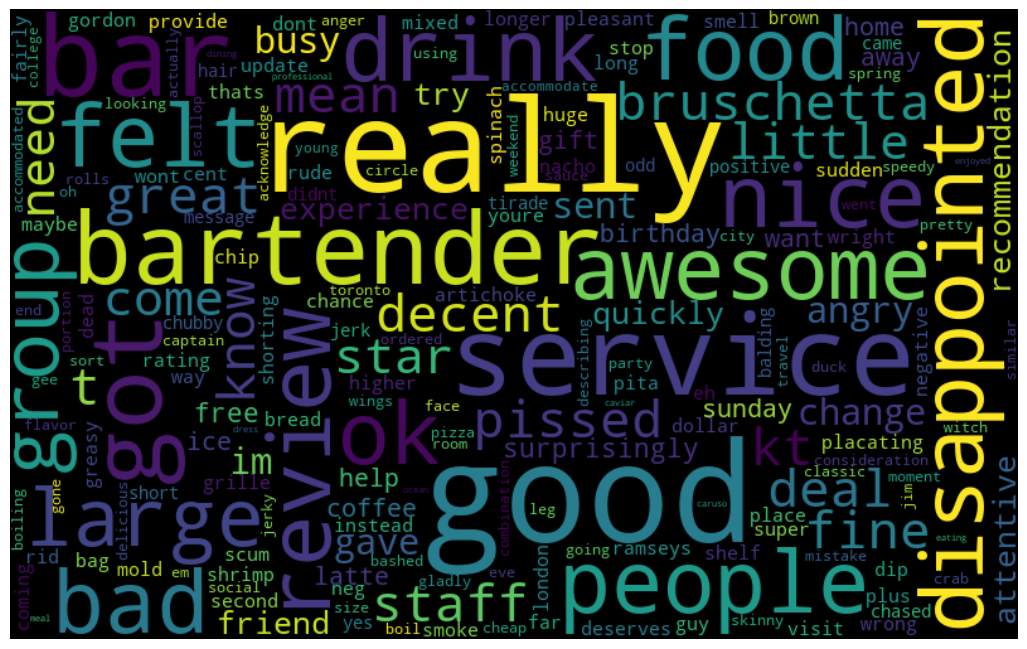

In [17]:
from wordcloud import WordCloud 
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(str(df['review_text'])) 
plt.figure(1,figsize=(13, 10))
fig=plt.figure(1)
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis('off') 
plt.show()
fig.savefig('/Users/vaishnavisingh/Desktop/wordcloud.png')

In [18]:
#Use CountVectorizer to get bigrams to visualize
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(max_df = 0.95, min_df = 2, stop_words= 'english', max_features=10000, ngram_range=(1,3))
X = cv.fit_transform(df['review_text'])

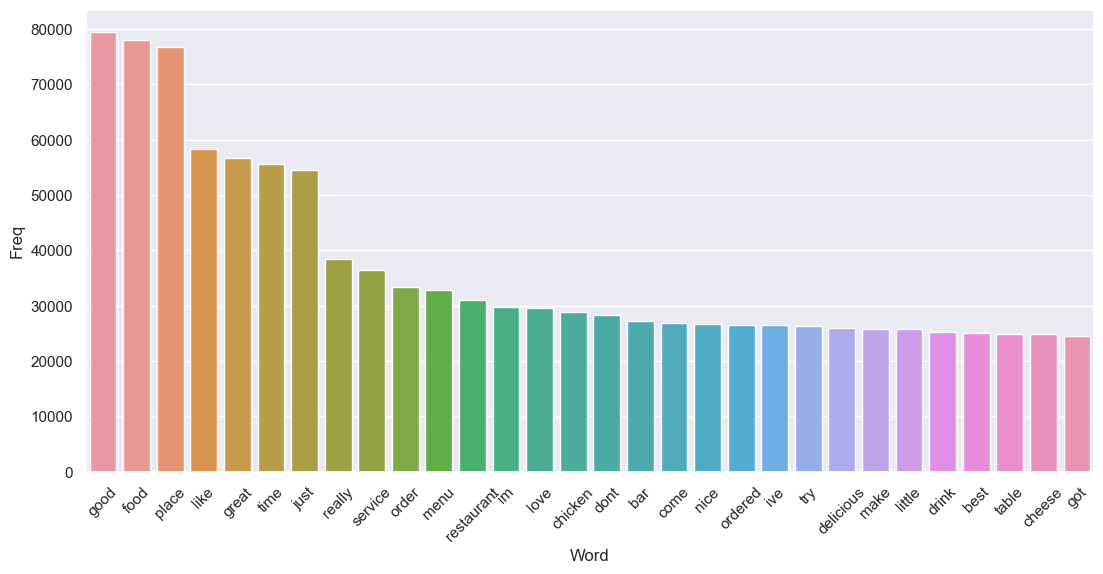

In [19]:
# Most frequently occuring words
def get_top_n_words(corpus,n=None):
    vec = CountVectorizer().fit(df['review_text'])
    bag_of_words=vec.transform(df['review_text'])
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word , idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
# Convert most freq words to datafame for visuals

top_words = get_top_n_words(df['review_text'], n=30)
top_df = pd.DataFrame(top_words)
top_df.columns = ['Word', 'Freq']

# barplot of most freq words
import seaborn as sns
sns.set(rc={'figure.figsize':(13,6)})
g = sns.barplot(x='Word', y='Freq', data=top_df)
g.set_xticklabels(g.get_xticklabels(), rotation=45)
fig = g.get_figure()
fig.savefig("/Users/vaishnavisingh/Desktop/sns_output.png")


             Bi-gram  Freq
0          ice cream  6103
1       food service  3365
2       service food  2934
3   customer service  2893
4        new orleans  2718
5        parking lot  2536
6         mac cheese  1960
7         place food  1860
8           st louis  1601
9           bar area  1548
10         food food  1544
11    beer selection  1451
12       dining room  1400
13      lunch dinner  1384
14        food place  1334
15       coffee shop  1312
16      quality food  1241
17        menu items  1158
18         time time  1151
19         time food  1150
20       chips salsa  1141
21        drive thru  1118
22       food drinks  1099
23        order food  1091
24       place place  1083
25      cream cheese  1056
26     grocery store  1052
27     peanut butter   998
28          bar food   989
29      friday night   989


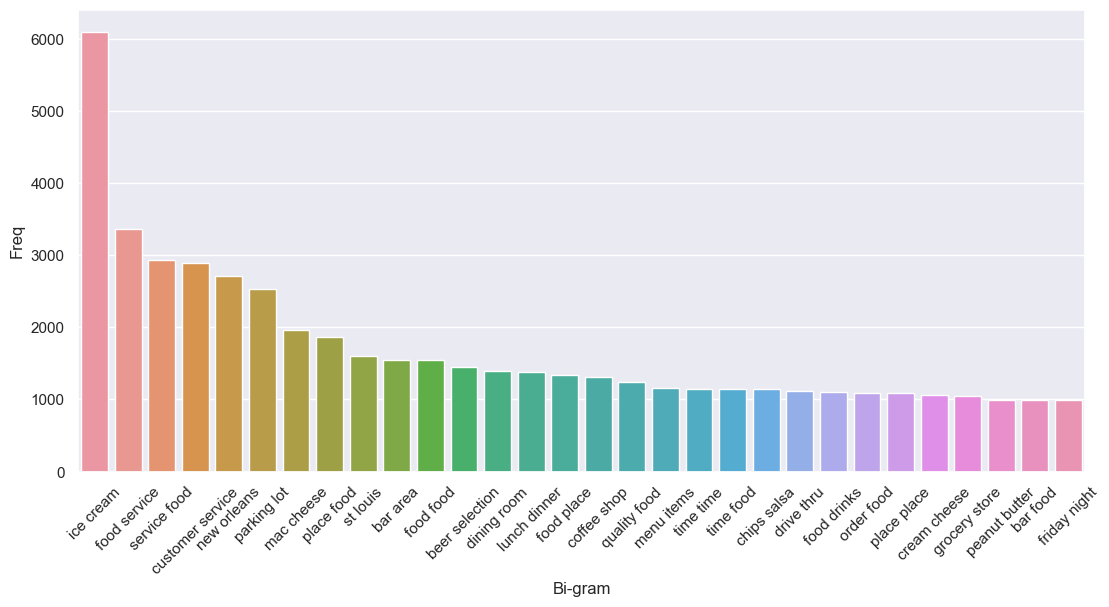

In [20]:
# Most frequently Co-occuring words
def get_top_n2_words(corpus,n=None):
    vec1 = CountVectorizer(ngram_range=(2,2),max_features=2000).fit(df['data_nouns'])
    bag_of_words=vec1.transform(df['data_nouns'])
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word , idx in vec1.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
# Convert most freq words to datafame for visuals

top2_words = get_top_n2_words(df['data_nouns'], n=30)
top2_df = pd.DataFrame(top2_words)
top2_df.columns = ['Bi-gram', 'Freq']

# for bigram wordcloud
top100_words = get_top_n2_words(df['data_nouns'], n=100)
top100_df = pd.DataFrame(top100_words)
top100_df.columns = ['Bi-gram', 'Freq']
print(top2_df)

# barplot of most freq words
import seaborn as sns
sns.set(rc={'figure.figsize':(13,6)})
h = sns.barplot(x='Bi-gram', y='Freq', data=top2_df)
h.set_xticklabels(h.get_xticklabels(), rotation=45)
fig = h.get_figure()
fig.savefig("/Users/vaishnavisingh/Desktop/sns_output_bigrams.png")

In [21]:
top100_df.head()


Bi-gram  Freq
0         ice cream  6103
1      food service  3365
2      service food  2934
3  customer service  2893
4       new orleans  2718

In [22]:
top100_df['Bi_gram'] = top100_df['Bi-gram'].str.replace(' ','_')
top100_df.head()

Bi-gram  Freq           Bi_gram
0         ice cream  6103         ice_cream
1      food service  3365      food_service
2      service food  2934      service_food
3  customer service  2893  customer_service
4       new orleans  2718       new_orleans

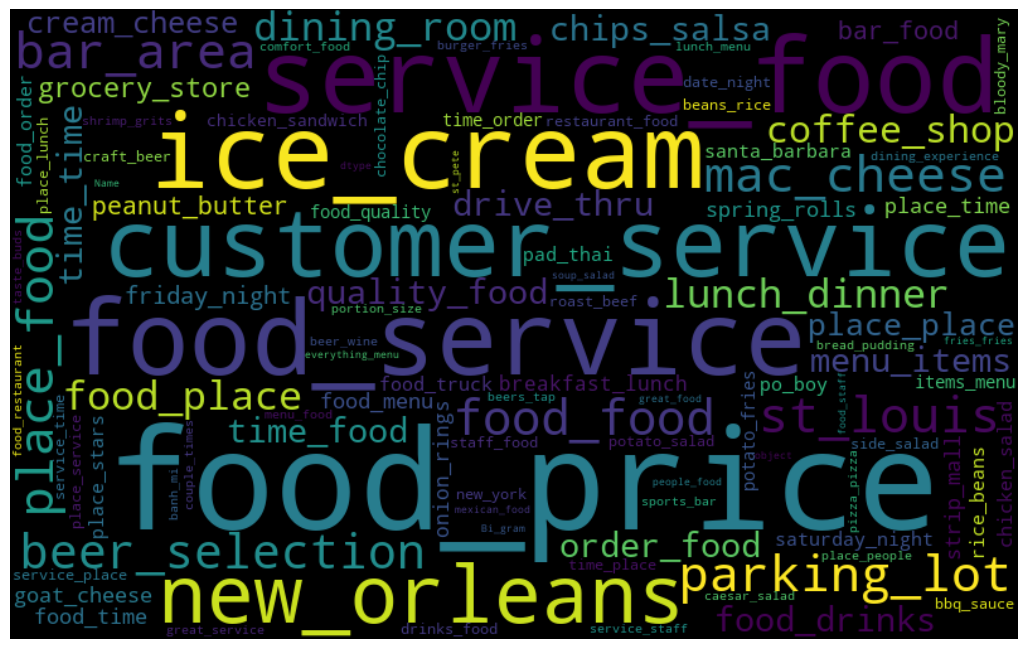

In [23]:
from wordcloud import WordCloud 
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(str(top100_df['Bi_gram'])) 
plt.figure(1,figsize=(13, 10))
fig=plt.figure(1)
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis('off') 
plt.show()
fig.savefig('/Users/vaishnavisingh/Desktop/wordcloud_bigram')

In [24]:
no_features = 50000


### Term vectorization term weighting: ###




In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_df = 0.95, min_df = 2, stop_words= 'english', max_features=no_features, ngram_range=(1,1),
                                  analyzer='word')
tfidf = tfidf_vectorizer.fit_transform(df['review_text'])
# get the feature names
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()


In [26]:
print('Vocabulary has %d distinct terms' % len(tfidf_feature_names))


Vocabulary has 43892 distinct terms


In [27]:
import operator
def rank_terms( tfidf, tfidf_feature_names ):
    # get the sums over each column
    sums = tfidf.sum(axis=0)
    # map weights to the terms
    weights = {}
    for col, term in enumerate(tfidf_feature_names):
        weights[term] = sums[0,col]
    # rank the terms by their weight over all documents
    return sorted(weights.items(), key=operator.itemgetter(1), reverse=True)

In [28]:
ranking = rank_terms(tfidf, tfidf_feature_names)
for i, pair in enumerate( ranking[0:20] ):
    print( "%02d. %s (%.0f)" % ( i+1, pair[0], pair[1] ) )

01. good (3166)
02. food (3127)
03. place (3064)
04. great (2811)
05. time (2307)
06. like (2232)
07. just (2131)
08. service (1967)
09. really (1833)
10. love (1745)
11. chicken (1632)
12. order (1620)
13. menu (1570)
14. pizza (1534)
15. nice (1521)
16. restaurant (1516)
17. bar (1489)
18. best (1485)
19. delicious (1478)
20. im (1450)


### Reviews having NMF model fitting ###


In [29]:
no_topics = 30

In [30]:
nmf=NMF(n_components = no_topics, random_state =1, alpha_W=0.0, alpha_H=0.0, l1_ratio = 0.5, init= 'nndsvd').fit(tfidf)


In [31]:

def display_topics(model, feature_names, no_top_words):
    if len(feature_names) != model.components_.shape[1]:
        raise ValueError("Number of feature names does not match model components.")
    
    col1 = 'topic'
    col2 = 'top_ten_words'
    dct = {col1: [], col2: []}
    for topic_idx, topic in enumerate(model.components_):
        top_words = [feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]
        dct[col1].append(str(topic_idx))
        dct[col2].append(" ".join(top_words))
        print(f"Topic {topic_idx}: {top_words}")
    return pd.DataFrame.from_dict(dct)

# Assuming you have defined nmf and tfidf_feature_names correctly
no_top_words = 10
topic_word = display_topics(nmf, tfidf_feature_names, no_top_words)
topic_word


Topic 0: ['place', 'like', 'just', 'dont', 'really', 'im', 'know', 'want', 'thing', 'think']
Topic 1: ['pizza', 'crust', 'slice', 'topping', 'pie', 'pepperoni', 'oven', 'delivery', 'sauce', 'garlic']
Topic 2: ['great', 'service', 'place', 'atmosphere', 'awesome', 'selection', 'price', 'spot', 'amazing', 'definitely']
Topic 3: ['coffee', 'shop', 'latte', 'starbucks', 'cup', 'iced', 'espresso', 'pastry', 'cafe', 'morning']
Topic 4: ['burger', 'fry', 'bun', 'onion', 'shake', 'bacon', 'patty', 'cooked', 'ring', 'juicy']
Topic 5: ['sushi', 'roll', 'tuna', 'salmon', 'fish', 'tempura', 'spicy', 'sashimi', 'fresh', 'chef']
Topic 6: ['salsa', 'mexican', 'chip', 'burrito', 'margarita', 'bean', 'fresh', 'tortilla', 'rice', 'enchilada']
Topic 7: ['ice', 'cream', 'chocolate', 'flavor', 'cone', 'cake', 'scoop', 'vanilla', 'dessert', 'cooky']
Topic 8: ['taco', 'fish', 'tuesday', 'tortilla', 'pork', 'bell', 'asada', 'pastor', 'corn', 'truck']
Topic 9: ['store', 'grocery', 'item', 'price', 'produce', '

topic  \
0      0   
1      1   
2      2   
3      3   
4      4   
5      5   
6      6   
7      7   
8      8   
9      9   
10    10   
11    11   
12    12   
13    13   
14    14   
15    15   
16    16   
17    17   
18    18   
19    19   
20    20   
21    21   
22    22   
23    23   
24    24   
25    25   
26    26   
27    27   
28    28   
29    29   

                                                                     top_ten_words  
0                             place like just dont really im know want thing think  
1               pizza crust slice topping pie pepperoni oven delivery sauce garlic  
2   great service place atmosphere awesome selection price spot amazing definitely  
3                coffee shop latte starbucks cup iced espresso pastry cafe morning  
4                         burger fry bun onion shake bacon patty cooked ring juicy  
5                     sushi roll tuna salmon fish tempura spicy sashimi fresh chef  
6          salsa mexican chip burrito margarita bean fresh tortilla rice enchilada  
7                 ice cream chocolate flavor cone cake scoop vanilla dessert cooky  
8                     taco fish tuesday tortilla pork bell asada pastor corn truck  
9          store grocery item price produce selection market shopping section shop  
10                 wine restaurant menu dish dinner meal dessert dining room table  
11                 good really pretty nice price service overall little got decent  
12                      sandwich bread bagel cuban turkey deli roast beef sub soup  
13         breakfast egg toast brunch pancake bacon french biscuit sausage morning  
14                        order minute came ordered got table wait didnt time took  
15                      beer selection tap brewery craft brew local draft ale wine  
16                    lunch special buffet dinner today day menu quick option soup  
17                  chicken fried rice waffle hot tender spicy crispy breast piece  
18                salad soup dressing fresh greek tomato potato pasta caesar bread  
19                            time ive best im year tried come favorite visit long  
20                              thai pho noodle soup dish rice curry beef pad bowl  
21             donut cake chocolate glazed dunkin sweet fresh dozen cupcake bakery  
22    love favorite place amazing absolutely awesome delicious coming super family  
23     food service fast restaurant quality price excellent star delicious amazing  
24                   bar drink hour happy night bartender cocktail music area game  
25                     shrimp oyster crab seafood fried fish cake gumbo po lobster  
26                        tea boba bubble milk drink sweet iced green fruit flavor  
27                           cheese sauce bbq meat mac steak pork rib sweet potato  
28        location staff friendly clean nice parking starbucks drive super seating  
29                     wing hot sauce buffalo fry order spicy boneless game garlic

In [32]:
no_top_words = 3
topic_word_3 = display_topics(nmf, tfidf_feature_names, no_top_words)
topic_word_3['Theme'] = topic_word_3.top_ten_words.str.title()
topic_word_4 = topic_word_3.loc[:,['topic', 'Theme']]
topic_word_4

Topic 0: ['place', 'like', 'just']
Topic 1: ['pizza', 'crust', 'slice']
Topic 2: ['great', 'service', 'place']
Topic 3: ['coffee', 'shop', 'latte']
Topic 4: ['burger', 'fry', 'bun']
Topic 5: ['sushi', 'roll', 'tuna']
Topic 6: ['salsa', 'mexican', 'chip']
Topic 7: ['ice', 'cream', 'chocolate']
Topic 8: ['taco', 'fish', 'tuesday']
Topic 9: ['store', 'grocery', 'item']
Topic 10: ['wine', 'restaurant', 'menu']
Topic 11: ['good', 'really', 'pretty']
Topic 12: ['sandwich', 'bread', 'bagel']
Topic 13: ['breakfast', 'egg', 'toast']
Topic 14: ['order', 'minute', 'came']
Topic 15: ['beer', 'selection', 'tap']
Topic 16: ['lunch', 'special', 'buffet']
Topic 17: ['chicken', 'fried', 'rice']
Topic 18: ['salad', 'soup', 'dressing']
Topic 19: ['time', 'ive', 'best']
Topic 20: ['thai', 'pho', 'noodle']
Topic 21: ['donut', 'cake', 'chocolate']
Topic 22: ['love', 'favorite', 'place']
Topic 23: ['food', 'service', 'fast']
Topic 24: ['bar', 'drink', 'hour']
Topic 25: ['shrimp', 'oyster', 'crab']
Topic 26: 

topic                    Theme
0      0          Place Like Just
1      1        Pizza Crust Slice
2      2      Great Service Place
3      3        Coffee Shop Latte
4      4           Burger Fry Bun
5      5          Sushi Roll Tuna
6      6       Salsa Mexican Chip
7      7      Ice Cream Chocolate
8      8        Taco Fish Tuesday
9      9       Store Grocery Item
10    10     Wine Restaurant Menu
11    11       Good Really Pretty
12    12     Sandwich Bread Bagel
13    13      Breakfast Egg Toast
14    14        Order Minute Came
15    15       Beer Selection Tap
16    16     Lunch Special Buffet
17    17       Chicken Fried Rice
18    18      Salad Soup Dressing
19    19            Time Ive Best
20    20          Thai Pho Noodle
21    21     Donut Cake Chocolate
22    22      Love Favorite Place
23    23        Food Service Fast
24    24           Bar Drink Hour
25    25       Shrimp Oyster Crab
26    26          Tea Boba Bubble
27    27         Cheese Sauce Bbq
28    28  Location Staff Friendly
29    29           Wing Hot Sauce

In [33]:
# Merge the theme with the top_ten
topic_word = pd.merge(topic_word_4, topic_word, on ='topic')
topic_word

topic                    Theme  \
0      0          Place Like Just   
1      1        Pizza Crust Slice   
2      2      Great Service Place   
3      3        Coffee Shop Latte   
4      4           Burger Fry Bun   
5      5          Sushi Roll Tuna   
6      6       Salsa Mexican Chip   
7      7      Ice Cream Chocolate   
8      8        Taco Fish Tuesday   
9      9       Store Grocery Item   
10    10     Wine Restaurant Menu   
11    11       Good Really Pretty   
12    12     Sandwich Bread Bagel   
13    13      Breakfast Egg Toast   
14    14        Order Minute Came   
15    15       Beer Selection Tap   
16    16     Lunch Special Buffet   
17    17       Chicken Fried Rice   
18    18      Salad Soup Dressing   
19    19            Time Ive Best   
20    20          Thai Pho Noodle   
21    21     Donut Cake Chocolate   
22    22      Love Favorite Place   
23    23        Food Service Fast   
24    24           Bar Drink Hour   
25    25       Shrimp Oyster Crab   
26    26          Tea Boba Bubble   
27    27         Cheese Sauce Bbq   
28    28  Location Staff Friendly   
29    29           Wing Hot Sauce   

                                                                     top_ten_words  
0                             place like just dont really im know want thing think  
1               pizza crust slice topping pie pepperoni oven delivery sauce garlic  
2   great service place atmosphere awesome selection price spot amazing definitely  
3                coffee shop latte starbucks cup iced espresso pastry cafe morning  
4                         burger fry bun onion shake bacon patty cooked ring juicy  
5                     sushi roll tuna salmon fish tempura spicy sashimi fresh chef  
6          salsa mexican chip burrito margarita bean fresh tortilla rice enchilada  
7                 ice cream chocolate flavor cone cake scoop vanilla dessert cooky  
8                     taco fish tuesday tortilla pork bell asada pastor corn truck  
9          store grocery item price produce selection market shopping section shop  
10                 wine restaurant menu dish dinner meal dessert dining room table  
11                 good really pretty nice price service overall little got decent  
12                      sandwich bread bagel cuban turkey deli roast beef sub soup  
13         breakfast egg toast brunch pancake bacon french biscuit sausage morning  
14                        order minute came ordered got table wait didnt time took  
15                      beer selection tap brewery craft brew local draft ale wine  
16                    lunch special buffet dinner today day menu quick option soup  
17                  chicken fried rice waffle hot tender spicy crispy breast piece  
18                salad soup dressing fresh greek tomato potato pasta caesar bread  
19                            time ive best im year tried come favorite visit long  
20                              thai pho noodle soup dish rice curry beef pad bowl  
21             donut cake chocolate glazed dunkin sweet fresh dozen cupcake bakery  
22    love favorite place amazing absolutely awesome delicious coming super family  
23     food service fast restaurant quality price excellent star delicious amazing  
24                   bar drink hour happy night bartender cocktail music area game  
25                     shrimp oyster crab seafood fried fish cake gumbo po lobster  
26                        tea boba bubble milk drink sweet iced green fruit flavor  
27                           cheese sauce bbq meat mac steak pork rib sweet potato  
28        location staff friendly clean nice parking starbucks drive super seating  
29                     wing hot sauce buffalo fry order spicy boneless game garlic

In [34]:
nmf_W = nmf.transform(tfidf)
nmf_H = nmf.components_

is_sorted = all(df['Doc_Id'] == range(len(nmf_W)))


In [35]:

df2 = pd.DataFrame({'topic': nmf_W.argmax(axis=1),
                    'Doc_Id': df['Doc_Id'],
                    'Review': df['review_text']},
                   columns=['topic', 'Doc_Id', 'Review'])



In [36]:

def showdocs(df2, topics, nshow=len(df) ): # nshow= len(df1)
    idx = df2.topic == topics[0]
    for i in range(1, len(topics)):
        idx = idx | (df2.topic == topics[i])
    return df2[idx].groupby('topic').head(nshow).sort_values('topic')

In [37]:
numbers = tuple(list(range(0, no_topics)))
final = showdocs(df2, numbers)
final.head(10)

topic  Doc_Id  \
0          0       0   
84973      0   84973   
59157      0   59157   
59183      0   59183   
59186      0   59186   
35649      0   35649   
35635      0   35635   
59218      0   59218   
8696       0    8696   
59135      0   59135   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             Review  
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   disappointed dont bruschetta really bad deal stop placating people wrong deal bad service sudden really bad really disappointed  
84973                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             :  
59157                                                                  damn didnt want like place looked like chain im atlanta greek restaurant mom&pop shop best gyro long pita bread warm extremely fresh gyro pretty decent size falafal fantastic - greasy tastey going sound weird love way cut lettuce gyro -its shredded place flacid unappetizing chard lettuce place different location right gulf bay near big target shopping center actually nice place sit enjoy lunch ton window let lot light actual comfortable chair little outdoor seating area eat - bonus service - friendly prompt ask better waiting food fulfilling order right left huge cake order cake prepared feed army  
59183   place divine came friend sweet tooth im glad gave naughty dessert desire place epitome charm walked breath taken away mean place like pinterest dream clean line wide open space sophisticated philadelphia vibe cinnamon gelato espresso delicious remember home training didnt lick glass friend wendy flight uh yeah flight flavor vegan chocolate know seeing word vegan make lot people hesitant unreal flavor just believed regular chocolate owner warm inviting took time tell spoke candidly italy place family owned operated wife did design work inside doe work kitchen live closer gelato place town definitely taking extra time instead dont mind bit bite worth extra step  
59186                                            oh southern living heart place just charming mean really like boyfriend ventured sunday early afternoon mistake place get packed stay packed day long want wait definitely try come earlier day close 3 youll feel pressure cut ordered l t avocado lettuce tomato pesto mayo thrown good measure damn good san

In [38]:
topic_word['topic']=pd.to_numeric(topic_word['topic'])
topic_body_2 =pd.merge(topic_word, final,on='topic')
topic_body_2

topic            Theme  \
0           0  Place Like Just   
1           0  Place Like Just   
2           0  Place Like Just   
3           0  Place Like Just   
4           0  Place Like Just   
...       ...              ...   
102321     29   Wing Hot Sauce   
102322     29   Wing Hot Sauce   
102323     29   Wing Hot Sauce   
102324     29   Wing Hot Sauce   
102325     29   Wing Hot Sauce   

                                                      top_ten_words  Doc_Id  \
0              place like just dont really im know want thing think       0   
1              place like just dont really im know want thing think   84973   
2              place like just dont really im know want thing think   59157   
3              place like just dont really im know want thing think   59183   
4              place like just dont really im know want thing think   59186   
...                                                             ...     ...   
102321  wing hot sauce buffalo fry order spicy boneless game garlic   16450   
102322  wing hot sauce buffalo fry order spicy boneless game garlic   29135   
102323  wing hot sauce buffalo fry order spicy boneless game garlic   72225   
102324  wing hot sauce buffalo fry order spicy boneless game garlic   52395   
102325  wing hot sauce buffalo fry order spicy boneless game garlic   78661   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         Review  
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               disappointed dont bruschetta really bad deal stop placating people wrong deal bad service sudden really bad really disappointed  
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

In [39]:
df =pd.read_pickle('/Users/vaishnavisingh/Desktop/df.pkl')

In [40]:
topic_body_3 = pd.merge(topic_body_2, df, on="Doc_Id")
topic_body_3.head()

topic            Theme  \
0      0  Place Like Just   
1      0  Place Like Just   
2      0  Place Like Just   
3      0  Place Like Just   
4      0  Place Like Just   

                                          top_ten_words  Doc_Id  \
0  place like just dont really im know want thing think       0   
1  place like just dont really im know want thing think   84973   
2  place like just dont really im know want thing think   59157   
3  place like just dont really im know want thing think   59183   
4  place like just dont really im know want thing think   59186   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         Review  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               disappointed dont bruschetta really bad deal stop placating people wrong deal bad service sudden really bad really disappointed   
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             :   
2                                                                  damn didnt want like place looked like chain im atlanta greek restaurant mom&pop shop best gyro long pita bread warm extremely fresh gyro pretty decent size falafal fantastic - greasy tastey going sound weird love way cut lettuce gyro -its shredded place flacid unappetizing chard lettuce place different location right gulf bay near big target shopping center actually nice place sit enjoy lunch ton window let lot light actual comfortable chair little outdoor seating area eat - bonus service - friendly prompt ask better waiting food fulfilling order right left huge cake order cake prepared feed army   
3   place divine came friend sweet tooth im glad gave naughty dessert desire place epitome charm walked breath taken away mean place like pinterest dream clean line wide open space sophisticated philadelphia vibe cinnamon gelato espresso delicious remember home training didnt lick glass friend wendy flight uh yeah flight flavor vegan chocolate know seeing word vegan make lot people hesitant unreal flavor just believed regular chocolate owner warm inviting took time tell spoke candidly italy place family owned operated wife did design work inside doe work kitchen live closer gelato place town definitely taking extra time instead dont mind bit bite worth extra step   
4                                            oh so

In [41]:
pd.set_option('max_colwidth', 1000)
pd.options.display.max_rows = 500


In [42]:
df = pd.read_pickle('data_prep.pkl')

In [43]:
kmin, kmax = 4, 50
# number of k is for 30 min processing, done for thoroughness


In [44]:
from sklearn.feature_extraction import text
my_stop_words = list(text.ENGLISH_STOP_WORDS)

vectorizer = TfidfVectorizer(stop_words=my_stop_words, min_df = 20)
A = vectorizer.fit_transform(df['review_text'])
terms = vectorizer.get_feature_names_out()

In [45]:
from sklearn import decomposition
topic_models = []
# try each value of k
for k in range(kmin,kmax+1):
    print("Applying NMF for k=%d ..." % k )
    # run NMF
    model = decomposition.NMF(random_state =1, init="nndsvd", n_components=k ) 
    W = model.fit_transform( A )
    H = model.components_    
    # store for later
    topic_models.append( (k,W,H) )

Applying NMF for k=4 ...
Applying NMF for k=5 ...
Applying NMF for k=6 ...
Applying NMF for k=7 ...
Applying NMF for k=8 ...
Applying NMF for k=9 ...
Applying NMF for k=10 ...
Applying NMF for k=11 ...
Applying NMF for k=12 ...
Applying NMF for k=13 ...
Applying NMF for k=14 ...
Applying NMF for k=15 ...
Applying NMF for k=16 ...
Applying NMF for k=17 ...
Applying NMF for k=18 ...
Applying NMF for k=19 ...
Applying NMF for k=20 ...
Applying NMF for k=21 ...
Applying NMF for k=22 ...
Applying NMF for k=23 ...
Applying NMF for k=24 ...
Applying NMF for k=25 ...
Applying NMF for k=26 ...
Applying NMF for k=27 ...
Applying NMF for k=28 ...
Applying NMF for k=29 ...
Applying NMF for k=30 ...
Applying NMF for k=31 ...
Applying NMF for k=32 ...
Applying NMF for k=33 ...
Applying NMF for k=34 ...
Applying NMF for k=35 ...
Applying NMF for k=36 ...
Applying NMF for k=37 ...
Applying NMF for k=38 ...
Applying NMF for k=39 ...
Applying NMF for k=40 ...
Applying NMF for k=41 ...
Applying NMF for k

### Coherence Scoring using Word2Vec Embeddings 

In [46]:
import re
class TokenGenerator:
    def __init__( self, documents, stopwords ):
        self.documents = documents
        self.stopwords = stopwords
        self.tokenizer = re.compile( r"(?u)\b\w\w+\b" )

    def __iter__( self ):
        print("Building Word2Vec model ...")
        for doc in self.documents:
            tokens = []
            for tok in self.tokenizer.findall( doc ):
                if tok in self.stopwords:
                    tokens.append( "<stopword>" )
                elif len(tok) >= 2:
                    tokens.append( tok )
            yield tokens

In [47]:
raw_documents = []
for line in df['review_text']:
    ## I did not use cleaned because it caused an error I could not solve, the key for certain words did not exist because they were anomalous entries not commonly used in any sort of lexicon base
    raw_documents.append( line.strip().lower() )
print("Read %d raw text documents" % len(raw_documents))

Read 102326 raw text documents


In [48]:
stop_words = text.ENGLISH_STOP_WORDS


In [49]:
import gensim
docgen = TokenGenerator( raw_documents, stop_words )
# the model has 500 dimensions, the minimum document-term frequency is 20
w2v_model = gensim.models.Word2Vec(docgen, vector_size=500, min_count=20, sg=1)

Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...


In [50]:
print("Model has %d terms" % len(w2v_model.wv.key_to_index))


Model has 13340 terms


In [51]:
w2v_model.save("w2v-model.bin")


In [52]:
def calculate_coherence( w2v_model, term_rankings ):
    overall_coherence = 0.0
    for topic_index in range(len(term_rankings)):
        # check each pair of terms
        pair_scores = []
        for pair in combinations( term_rankings[topic_index], 2 ):
            pair_scores.append( w2v_model.similarity(pair[0], pair[1]) )
        # get the mean for all pairs in this topic
        topic_score = sum(pair_scores) / len(pair_scores)
        overall_coherence += topic_score
    # get the mean score across all topics
    return overall_coherence / len(term_rankings)

In [53]:
import numpy as np
def get_descriptor( all_terms, H, topic_index, top ):
    # reverse sort the values to sort the indices
    top_indices = np.argsort( H[topic_index,:] )[::-1]
    # now get the terms corresponding to the top-ranked indices
    top_terms = []
    for term_index in top_indices[0:top]:
        top_terms.append( all_terms[term_index] )
    return top_terms


In [54]:
from itertools import combinations

k_values = []
coherences = []

for (k, W, H) in topic_models:
    # Get all of the topic descriptors - the term_rankings, based on top 10 terms
    term_rankings = []
    for topic_index in range(k):
        term_rankings.append(get_descriptor(terms, H, topic_index, 10))
    
    # Now calculate the coherence based on our Word2Vec model
    k_values.append(k)
    coherences.append(calculate_coherence(w2v_model.wv, term_rankings))
    print("K=%02d: Coherence=%.4f" % (k, coherences[-1]))


K=04: Coherence=0.2695
K=05: Coherence=0.2703
K=06: Coherence=0.2722
K=07: Coherence=0.2746
K=08: Coherence=0.2806
K=09: Coherence=0.2890
K=10: Coherence=0.2884
K=11: Coherence=0.2950
K=12: Coherence=0.2956
K=13: Coherence=0.2973
K=14: Coherence=0.3047
K=15: Coherence=0.3038
K=16: Coherence=0.2955
K=17: Coherence=0.2967
K=18: Coherence=0.2915
K=19: Coherence=0.2874
K=20: Coherence=0.2905
K=21: Coherence=0.2849
K=22: Coherence=0.2862
K=23: Coherence=0.2841
K=24: Coherence=0.2876
K=25: Coherence=0.2856
K=26: Coherence=0.2862
K=27: Coherence=0.2837
K=28: Coherence=0.2841
K=29: Coherence=0.2846
K=30: Coherence=0.2854
K=31: Coherence=0.2859
K=32: Coherence=0.2789
K=33: Coherence=0.2801
K=34: Coherence=0.2818
K=35: Coherence=0.2831
K=36: Coherence=0.2819
K=37: Coherence=0.2841
K=38: Coherence=0.2813
K=39: Coherence=0.2809
K=40: Coherence=0.2820
K=41: Coherence=0.2783
K=42: Coherence=0.2781
K=43: Coherence=0.2861
K=44: Coherence=0.2796
K=45: Coherence=0.2780
K=46: Coherence=0.2807
K=47: Coher

In [55]:
import matplotlib
%matplotlib inline
plt.style.use("ggplot")
matplotlib.rcParams.update({"font.size": 11})

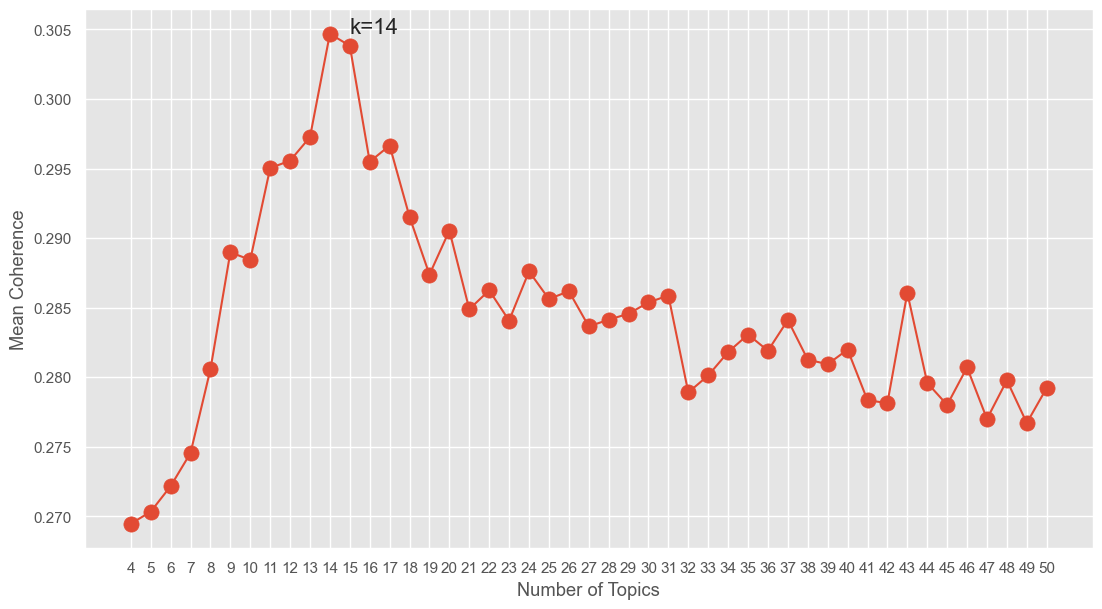

In [56]:
fig = plt.figure(figsize=(13,7))
# create the line plot
ax = plt.plot( k_values, coherences )
plt.xticks(k_values)
plt.xlabel("Number of Topics")
plt.ylabel("Mean Coherence")
# add the points
plt.scatter( k_values, coherences, s=120)
# find and annotate the maximum point on the plot
ymax = max(coherences)
xpos = coherences.index(ymax)
best_k = k_values[xpos]
plt.annotate( "k=%d" % best_k, xy=(best_k, ymax), xytext=(best_k, ymax), textcoords="offset points", fontsize=16)
# show the plot
plt.show()


In [57]:
k = best_k
# get the model that we generated earlier.
W = topic_models[k-kmin][1]
H = topic_models[k-kmin][2]

In [58]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 10 )
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: table, order, time, came, drink, ordered, wait, minute, server, got
Topic 02: pizza, crust, slice, cheese, pie, topping, sauce, pepperoni, salad, garlic
Topic 03: beer, bar, selection, wine, tap, drink, brewery, craft, game, bartender
Topic 04: coffee, shop, tea, latte, donut, iced, starbucks, cup, drink, milk
Topic 05: burger, fry, cheese, bun, onion, bacon, shake, patty, cooked, ring
Topic 06: great, food, service, place, love, staff, friendly, atmosphere, amazing, awesome
Topic 07: sushi, roll, tuna, lunch, fish, salmon, fresh, spicy, tempura, sashimi
Topic 08: ice, cream, chocolate, flavor, cake, cone, dessert, donut, sweet, vanilla
Topic 09: taco, salsa, mexican, chip, fish, burrito, tortilla, margarita, bean, guacamole
Topic 10: store, location, staff, parking, item, friendly, grocery, clean, lot, price
Topic 11: sandwich, breakfast, egg, cheese, lunch, bacon, bread, bagel, toast, salad
Topic 12: good, food, really, service, pretty, nice, price, fast, decent, place
Topi

In [59]:
final_dom = topic_body_2
final_dom.to_csv('/Users/vaishnavisingh/Desktop/y2s2/textMining/final_dom.csv', index=False)


In [60]:
def display_topics(nmf_model, feature_names, no_top_words):
    topic_word_final = {'Top Words': [], 'Theme': []}
    for topic_idx, topic in enumerate(nmf_model.components_):
        top_words = [feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]
        theme = topic_word_4['Theme'].iloc[topic_idx]  # Assuming 'Theme' is a column in topic_word_4 DataFrame
        topic_word_final['Top Words'].append(", ".join(top_words))
        topic_word_final['Theme'].append(theme)
    return pd.DataFrame(topic_word_final)

no_top_words = 3
topic_word_final = display_topics(nmf, tfidf_feature_names, no_top_words)
print(topic_word_final)



                    Top Words                    Theme
0           place, like, just          Place Like Just
1         pizza, crust, slice        Pizza Crust Slice
2       great, service, place      Great Service Place
3         coffee, shop, latte        Coffee Shop Latte
4            burger, fry, bun           Burger Fry Bun
5           sushi, roll, tuna          Sushi Roll Tuna
6        salsa, mexican, chip       Salsa Mexican Chip
7       ice, cream, chocolate      Ice Cream Chocolate
8         taco, fish, tuesday        Taco Fish Tuesday
9        store, grocery, item       Store Grocery Item
10     wine, restaurant, menu     Wine Restaurant Menu
11       good, really, pretty       Good Really Pretty
12     sandwich, bread, bagel     Sandwich Bread Bagel
13      breakfast, egg, toast      Breakfast Egg Toast
14        order, minute, came        Order Minute Came
15       beer, selection, tap       Beer Selection Tap
16     lunch, special, buffet     Lunch Special Buffet
17       c

Word clouds for each topic

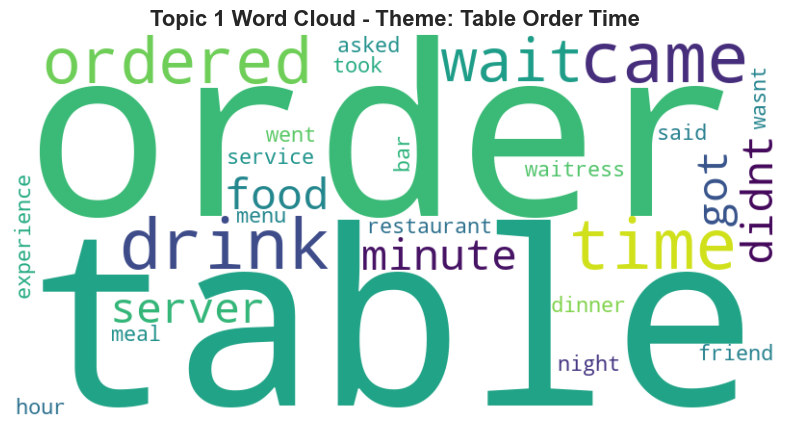

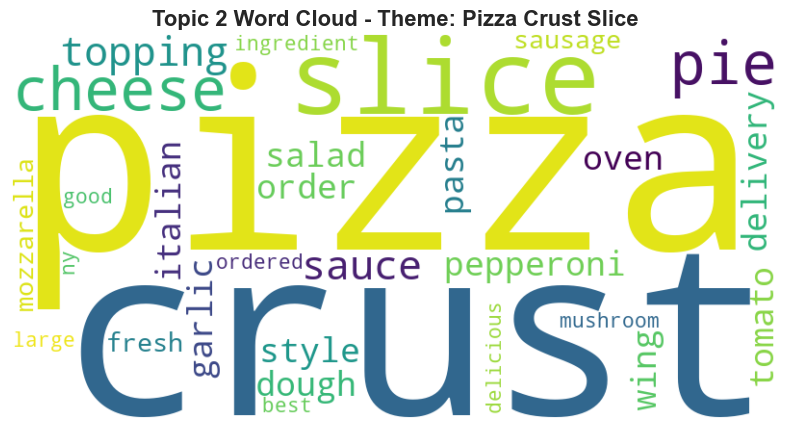

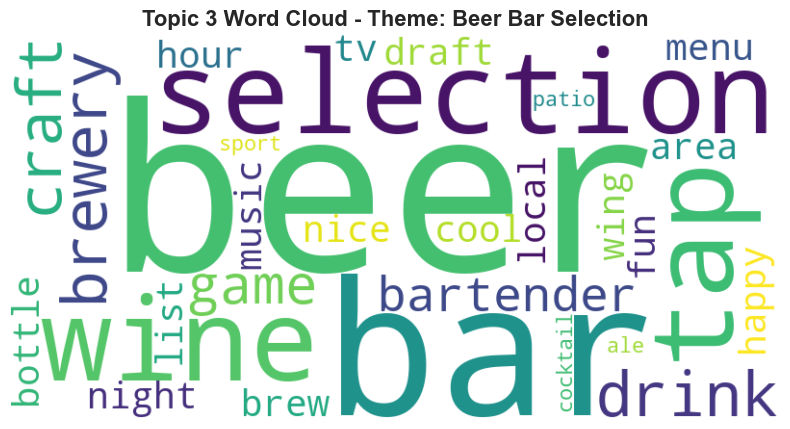

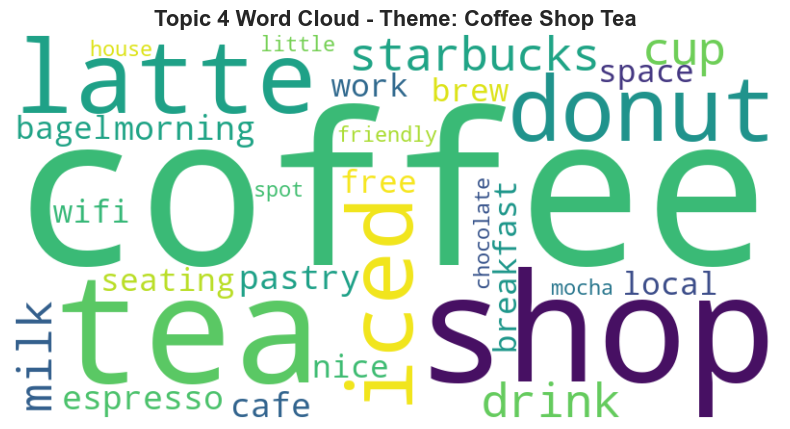

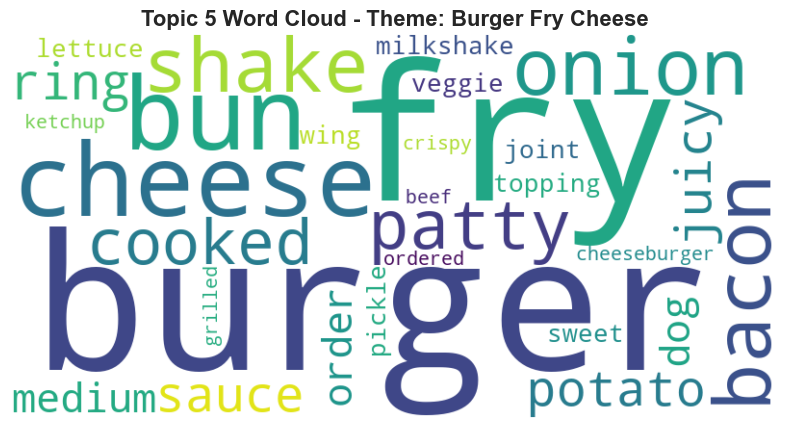

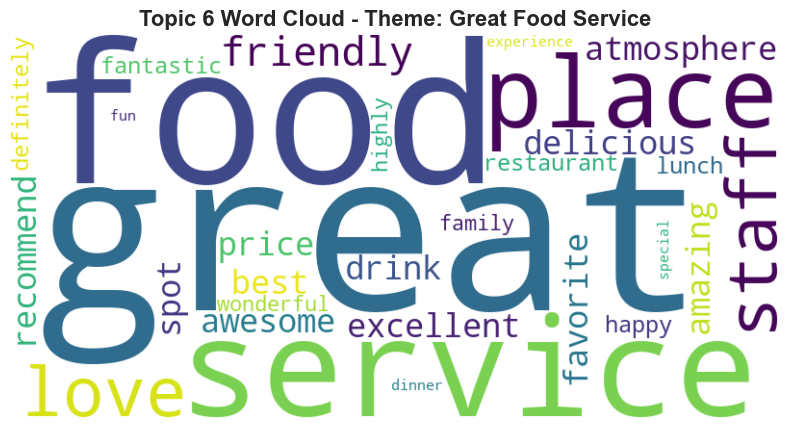

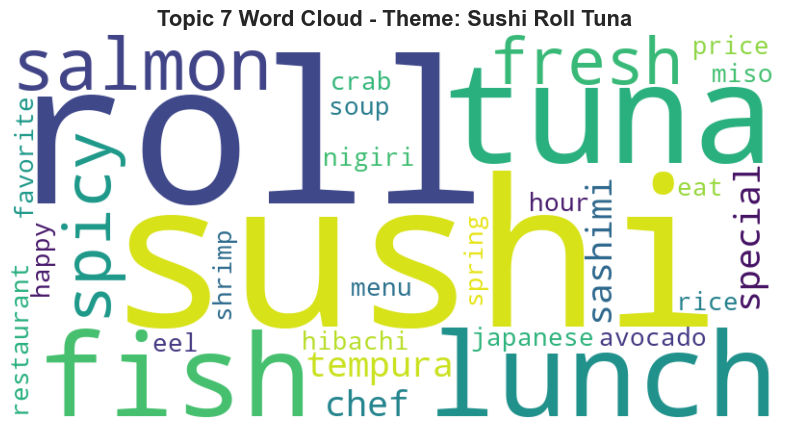

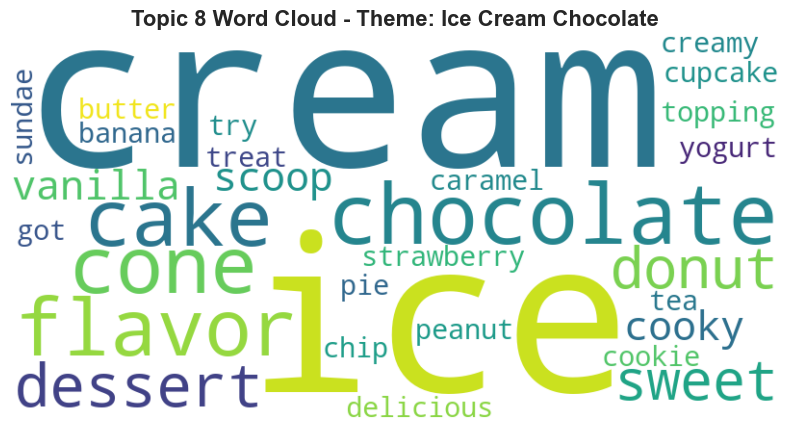

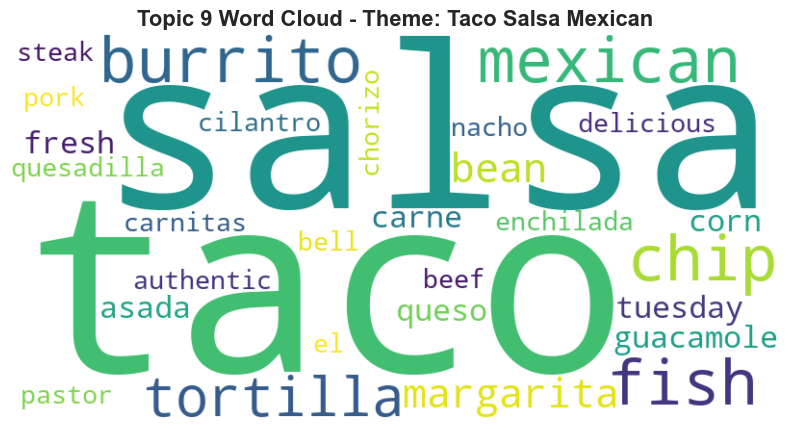

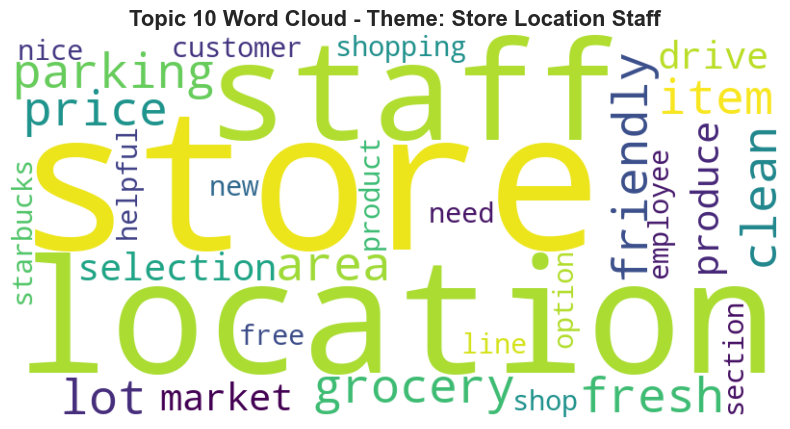

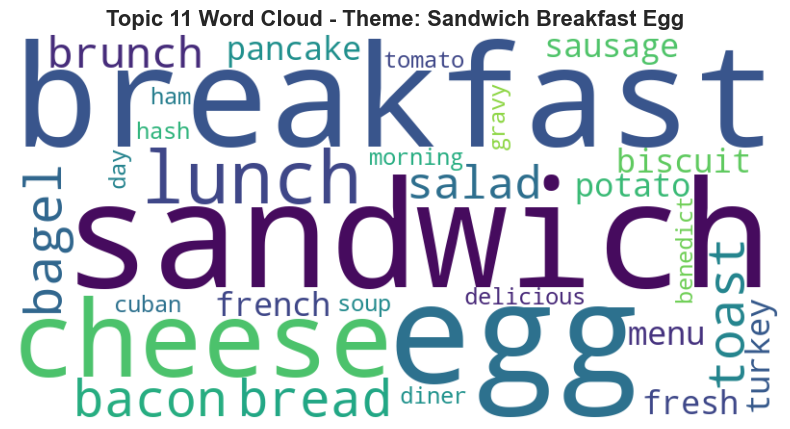

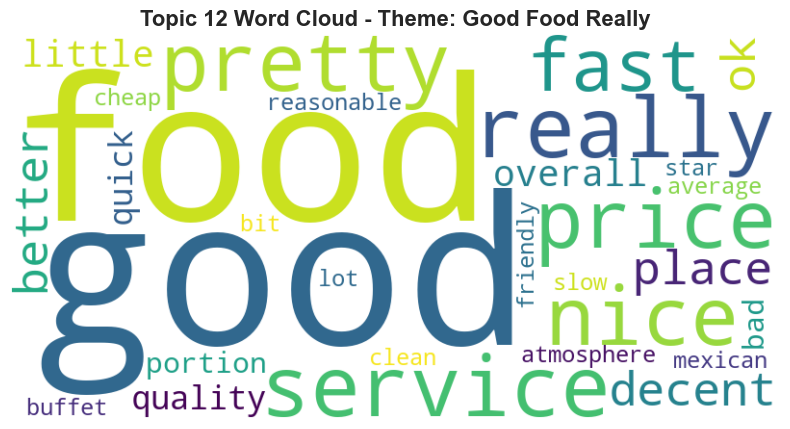

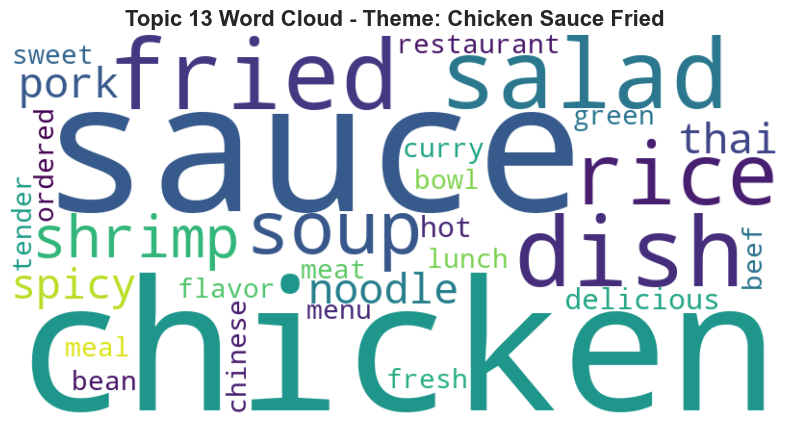

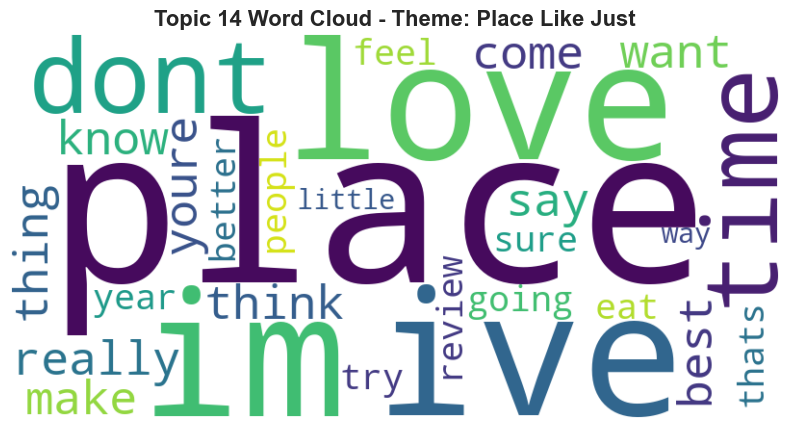

In [61]:
def generate_wordcloud(descriptor, topic_index):
    theme_words = descriptor[:3]  # Extract the top 3 words as the theme
    theme = " ".join([f"{word.capitalize()}" for word in theme_words])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(descriptor))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Topic {topic_index + 1} Word Cloud - Theme: {theme}', fontweight='bold')
    plt.show()

# Number of topics (k)
k = H.shape[0]

# Generate word clouds for each topic
for topic_index in range(k):
    descriptor = get_descriptor(terms, H, topic_index, 30)  # Change to the desired number of top terms
    generate_wordcloud(descriptor, topic_index)



### Perplexity Scores ### 


First need to fit nmf model to document term matrix


In [62]:
from sklearn.base import clone

cloned_nmf_model = clone(nmf)
vectorizer = TfidfVectorizer(stop_words='english')
tfidf = vectorizer.fit_transform(df['review_text'])

# Train the NMF model on the TF-IDF matrix
cloned_nmf_model.fit(tfidf)

NMF(alpha_H=0.0, init='nndsvd', l1_ratio=0.5, n_components=30, random_state=1)

Normalise topic word distributions for each word in each topic

*METHOD 1: Calculate the perplexity using the formula FAILED*

In [63]:
from sklearn.base import clone
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from tqdm import tqdm
import numpy as np

# Define the function to compute perplexity
def compute_perplexity(doc_index):
    word_indices = vectorizer.transform(terms).nonzero()[1]
    doc_topic_probs = cloned_nmf_model.transform(tfidf[doc_index])
    doc_prob = np.zeros(len(word_indices))
    for topic_index, topic_prob in enumerate(topic_word_probs):
        doc_prob += doc_topic_probs[0][topic_index] * topic_prob[word_indices]
    
    # Handle potential division by zero or NaN values
    doc_prob[doc_prob == 0] = np.nan
    doc_prob = np.nan_to_num(doc_prob)  # Replace NaN values with zero
    
    # Compute perplexity
    if np.any(doc_prob == 0):
        perplexity = np.inf  # Handle division by zero
    else:
        perplexity = np.exp(-np.sum(np.log(doc_prob)) / len(doc_prob))
    
    return perplexity

# Clone the NMF model
cloned_nmf_model = clone(nmf)

vectorizer = TfidfVectorizer(stop_words='english')

tfidf = vectorizer.fit_transform(df['review_text'])

# TF-IDF matrix with 14 topics
num_topics = 14
cloned_nmf_model.n_components = num_topics
cloned_nmf_model.fit(tfidf)

topic_word_probs = cloned_nmf_model.components_ / cloned_nmf_model.components_.sum(axis=1)[:, np.newaxis]

num_documents = tfidf.shape[0]
pbar = tqdm(total=num_documents, desc="Calculating Perplexity")

perplexities = []

for doc_index in range(num_documents):
    perplexity = compute_perplexity(doc_index)
    perplexities.append(perplexity)
    pbar.update(1)

# Close the tqdm progress bar
pbar.close()

# Compute average perplexity, ignoring infinity values
average_perplexity = np.mean([p for p in perplexities if p != np.inf])
print("Average Perplexity:", average_perplexity)



Calculating Perplexity: 100%|███████████| 102326/102326 [39:41<00:00, 42.97it/s]

Average Perplexity: 753932.3580230507


METHOD 2: ANOTHER FAIL

In [64]:
from sklearn.base import clone
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from tqdm import tqdm

cloned_nmf_model = clone(nmf)

param_grid = {
    'n_components': [14],
    'alpha_W': [0.1, 0.5, 1.0],
    'alpha_H': [0.1, 0.5, 1.0],
}

vectorizer = TfidfVectorizer(stop_words='english')
tfidf = vectorizer.fit_transform(df['review_text'])

grid_search = GridSearchCV(cloned_nmf_model, param_grid, cv=5, verbose=1, scoring='neg_mean_squared_error')

total_iterations = len(param_grid['n_components']) * len(param_grid['alpha_W']) * len(param_grid['alpha_H'])

with tqdm(total=total_iterations, desc="GridSearchCV Progress") as pbar:
    def fit_with_progress(self, X, y=None):
        self._original_fit(X, y)
        pbar.update(1)

    grid_search._original_fit = grid_search.fit
    grid_search.fit = fit_with_progress.__get__(grid_search)

    grid_search.fit(tfidf)

best_nmf_model = grid_search.best_estimator_
best_nmf_model.fit(tfidf)

best_params = grid_search.best_params_

print("Best Parameters:", best_params)

num_topics = best_nmf_model.n_components
word_indices = vectorizer.get_feature_names_out()

topic_word_probs = best_nmf_model.components_ / best_nmf_model.components_.sum(axis=1)[:, np.newaxis]

topic_word_probs_normalized = []
for topic_prob in topic_word_probs:
    total_prob = np.sum(topic_prob)
    normalized_prob = np.nan_to_num(topic_prob / total_prob)
    topic_word_probs_normalized.append(normalized_prob)


print("Normalized Topic-Word Probabilities:")
for i, topic_prob in enumerate(topic_word_probs_normalized):
    print(f"Topic {i}:")
    for j, prob in enumerate(topic_prob):
        print(f"    {word_indices[j]}: {prob:.4f}")



GridSearchCV Progress:   0%|                              | 0/9 [00:00<?, ?it/s]

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV Progress:   0%|                              | 0/9 [00:09<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
'''
### Checks because the above gives me NaN values:
# Check the TF-IDF matrix shape
print("TF-IDF Matrix Shape:", tfidf.shape)

# Check if the terms match the indices of topic-word probabilities
print("Number of Terms:", len(vectorizer.get_feature_names_out()))

# Check if the best NMF model is fitted properly
if hasattr(best_nmf_model, 'components_') and best_nmf_model.components_ is not None:
    print("Best NMF model is fitted properly.")
else:
    print("Best NMF model is not fitted properly.")

# Compute normalized topic-word probabilities
num_topics = best_nmf_model.n_components
word_indices = vectorizer.get_feature_names_out()

topic_word_probs = best_nmf_model.components_ / best_nmf_model.components_.sum(axis=1)[:, np.newaxis]

# Output the normalized topic-word probabilities
print("Normalized Topic-Word Probabilities:")
for i, topic_prob in enumerate(topic_word_probs):
    print(f"Topic {i}:")
    for j, prob in enumerate(topic_prob):
        print(f"    {word_indices[j]}: {prob:.4f}")
'''

'\n### Checks because the above gives me NaN values:\n# Check the TF-IDF matrix shape\nprint("TF-IDF Matrix Shape:", tfidf.shape)\n\n# Check if the terms match the indices of topic-word probabilities\nprint("Number of Terms:", len(vectorizer.get_feature_names_out()))\n\n# Check if the best NMF model is fitted properly\nif hasattr(best_nmf_model, \'components_\') and best_nmf_model.components_ is not None:\n    print("Best NMF model is fitted properly.")\nelse:\n    print("Best NMF model is not fitted properly.")\n\n# Compute normalized topic-word probabilities\nnum_topics = best_nmf_model.n_components\nword_indices = vectorizer.get_feature_names_out()\n\ntopic_word_probs = best_nmf_model.components_ / best_nmf_model.components_.sum(axis=1)[:, np.newaxis]\n\n# Output the normalized topic-word probabilities\nprint("Normalized Topic-Word Probabilities:")\nfor i, topic_prob in enumerate(topic_word_probs):\n    print(f"Topic {i}:")\n    for j, prob in enumerate(topic_prob):\n        print(f

New Evaluation Metric: Reconstruction Error *Fail 3*

In [ ]:
'''from sklearn.metrics import mean_squared_error
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm
from joblib import Parallel, delayed
import numpy as np

vectorizer = TfidfVectorizer(stop_words='english')
tfidf = vectorizer.fit_transform(df['review_text'])

tfidf_dense = tfidf.toarray()

nmf = NMF(n_components=14)  # Adjust the number of components as needed
nmf.fit(tfidf_dense)

def compute_reconstruction_error(i):
    tfidf_reconstructed_i = nmf.inverse_transform(nmf.transform(tfidf_dense[i].reshape(1, -1)))
    return mean_squared_error(tfidf_dense[i], tfidf_reconstructed_i.flatten())

total_documents = tfidf.shape[0]
with tqdm(total=total_documents, desc="Computing Reconstruction Error") as pbar:
    reconstruction_errors = Parallel(n_jobs=-1)(
        delayed(compute_reconstruction_error)(i) for i in range(total_documents)
    )
    pbar.update(total_documents)

mean_reconstruction_error = np.mean(reconstruction_errors)
print("Mean Reconstruction Error:", mean_reconstruction_error)'''

#### The above does not work either because kernel times out 

NameError: name 'df' is not defined